In [1]:
import os
from pathlib import Path

import pandas as pd
import tifffile
from tifffile import TiffFile
from ome_types import from_tiff, from_xml
import numpy as np
import PIL
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

from mgitools.os_helpers import listfiles

In [2]:

from deepcell.datasets import multiplex_tissue
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay
from deepcell.applications import Mesmer

In [3]:
# cant install full mip pipeline so redefining here
def extract_ome_tiff(fp):   
    tif = TiffFile(fp)
    ome = from_xml(tif.ome_metadata)
    im = ome.images[0]
    d = {}
    for c, p in zip(im.pixels.channels, tif.pages):
        img = p.asarray()
        d[c.name] = img
    return d

def get_ome_tiff_channels(fp):   
    tif = TiffFile(fp)
    ome = from_xml(tif.ome_metadata)
    im = ome.images[0]
    return [c.name for c in im.pixels.channels]

In [4]:
def merge_channels(channel_to_img, channels, thresh=.01, contrast_pct=95.):
    img = None
    for c in channels:
        if c not in channel_to_img:
            print(f'warning: {c} not in image')
            pass
        else:
            X = channel_to_img[c].copy().astype(np.float32)
            X -= X.min()
            X /= X.max()
            vmax = np.percentile(X[X>0], (contrast_pct)) if np.count_nonzero(X) else 1.
            X = rescale_intensity(X, in_range=(0., vmax))

            X = np.expand_dims(X, 0)

            if img is None:
                img = X
            else:
                img = np.concatenate((img, X), axis=0)

    img = np.mean(img, axis=0)
    return img

In [12]:
app = Mesmer()

def segment_cells(fp):
    channel_to_img = extract_ome_tiff(fp)
    
    channel_to_img = {r_channel_mapping.get(k, k):v for k, v in channel_to_img.items()}
    
    nuclei = merge_channels(channel_to_img, ['DAPI'])
    membrane = merge_channels(
        channel_to_img,
        membrane_channels)
    
#     input_img = np.concatenate((np.expand_dims(nuclei[r1:r2, c1:c2], axis=-1),
#                             np.expand_dims(membrane[r1:r2, c1:c2], axis=-1)), axis=-1)
    input_img = np.concatenate((np.expand_dims(nuclei, axis=-1),
                            np.expand_dims(membrane, axis=-1)), axis=-1)
    input_img = np.expand_dims(input_img, axis=0)
    
    segmentation_predictions = app.predict(input_img, compartment='both')
    
    labeled_cells, labeled_nuclei = segmentation_predictions[0, ..., 0], segmentation_predictions[0, ..., 1]
    
    return labeled_cells, labeled_nuclei
    

2023-05-15 17:57:10.086431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/estorrs/miniconda3/envs/mesmer/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-15 17:57:10.086459: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-15 17:57:10.087653: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other o

In [31]:
channel_mapping = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45RO'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)'],
    'ER': ['ER', 'ER-(D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN']
}
r_channel_mapping = {v:k for k, vs in channel_mapping.items() for v in vs}

membrane_channels = ['Pan-Cytokeratin', 'CD45', 'CD8', 'CD3e', 'Vimentin', 'SMA', 'CD31', 'CD20']

In [25]:
# r1, r2, c1, c2, = 9500, 10500, 10000, 11000

In [27]:
fps = sorted(listfiles('/data/multiplex_imaging/codex/htan/', regex=r'level_2/[^/]+.ome.tiff$'))
# fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/', regex=r'.*/level_2/[^/]+[PC][0-9][^/]+.*ome.tiff$'))
fps

['/data/multiplex_imaging/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_2/HT365B1_S1H1.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_2/HT271B1_S1H3A5.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT171B1-S1H9A1-4_04192023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_04192023.ome.tiff',
 '/data/multiplex_i

In [20]:
fps = [
    '/data/multiplex_imaging/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_2/HT365B1_S1H1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_2/HT271B1_S1H3A5.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT171B1-S1H9A1-4_04192023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_04192023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_04192023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT308B1-S1H5A4_04192023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT339B2-H1_04262023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT413C1-K2_04262023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT553P1-H2_04262023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT565B1-H2_04262023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1-S1H1A1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1-S1H1A4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT271B1-S1H3A5.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221122_BRCA_HT171B1_S1H1A1/level_2/HT171B1_S1H8A1_20221122.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221202_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1_S1H1A1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221202_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1_S1H1A4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221202_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT271B1_S1H3A5.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/20221205_BRCA_HT171B1_S1H1A4/level_2/HT171B1_20221205.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT206B1-H1/level_2/HT206B1-H1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_2/HT206B1_S1H2L4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_2/HT427P1_S1H1A3.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT206B1_H1_06252022/level_2/HT206B1_H1_06252022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT243B1-S1H4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT305B1-S1H1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT297B1-H1-08042022/level_2/HT297B1-H1-08042022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT323B1-H1-08042022/level_2/HT323B1-H1-08042022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT323B1-H1A1/level_2/HT323B1-H1A1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT323B1-H1A4/level_2/HT323B1-H1A4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT323B1-H3/level_2/HT323B1-H3.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT339B1-H1A1/level_2/HT339B1-H1A1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT339B1-H2A1/level_2/HT339B1-H2A1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT339B1-H4A4/level_2/HT339B1-H4A4.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT397B1-H2A2/level_2/HT397B1-H2A2.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT397B1-H3A1/level_2/HT397B1-H3A1.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT480B1-S1H2_reg001/level_2/HT480B1-S1H2-R001.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT480B1-S1H2_reg002/level_2/HT480B1-S1H2-R002.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_right_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_right_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_right_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_right_05122023.ome.tiff',
]

In [18]:
fps = [
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_right_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_right_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_right_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_left_05122023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_right_05122023.ome.tiff',
]

In [28]:
fps = [
    '/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT413C1-K2_04262023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT553P1-H2_04262023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_2/HT427P1_S1H1A3.ome.tiff',
    '/data/multiplex_imaging/codex/htan/brca/HT206B1-S1H2L4_and_HT427P1_S1H1A3/level_2/HT427P1_S1H1A3.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/041323_CRC_HT488C1-Th1K1Fp1-U2/level_2/HT488C1-Th1K1Fp1-U2_041323.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/041823_CRC_HT488C1-Th1K1Fp1-U14/level_2/HT488C1-Th1K1Fp1-U14_041823.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT342C1_Th1K4A1_section1_03042022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT342C1_Th1K4A1_section2_03042022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT347C1_Th1K2A1_section1_03042022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT347C1_Th1K2A1_section2_03042022.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/20230308_CRC_Primary_S15_1909_A3_Section3/level_2/S15_1909_A3_Section3_03082023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/crc/20230309_CRC_Met_S15_1909_C2_Section3/level_2/S15_1909_C2_Section3_03092023.ome.tiff',
    '/data/multiplex_imaging/codex/htan/pdac/HT434P1-H1/level_2/HT434P1-H1.ome.tiff'
]

In [29]:
channels = sorted(get_ome_tiff_channels(fps[0]))
pool = []
for fp in fps:
    ls = get_ome_tiff_channels(fp)
    print()
    print(fp.split('/')[-1])
    print(ls)
    pool += ls
    for c in ls:
        if c not in channels:
            print('missing in image', c)
    for c in channels:
        if c not in ls:
            print('missing in channels', c)


HT413C1-K2_04262023.ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'TFF1 (D)', 'MGP-(D)', 'a-Amylase', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD11b (D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'CK17-(D)', 'PLAT/tPA (D)', 'CTLA4', 'Hep-Par-1 (D)', 'CD4', 'SLC39A6', 'Keratin 5']

HT553P1-H2_04262023.ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'TFF1 (D)', 'MGP-(D)', 'a-Amylase', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD11b (D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'CK17-(D)', 'PLAT/tPA (D)', 'CTLA4', 'Hep-Par-1 (D)', 'CD4', 'SLC39A6', 'Keratin 5']

HT427P1_S1H1A3.ome.tiff
['DAPI', 'CK19 (D)', 'CD31', 'CD4', 'CD8', 'Pan-Cytokeratin', 'CD107a', 'Podoplanin', 'CK17 (D)', 'CD3e', 'Keratin 14', 'SMA (D)', 'CD68', 'CD20 (D)', 'V


S15_1909_A3_Section3_03082023.ome.tiff
['DAPI', 'Podoplanin', 'Pan-Cytokeratin', 'HLA-DR', 'CD8', 'SMA-(D)', 'CD68', 'CD20-(D)', 'Vimentin-(D)', 'CD31-(D)', 'Ki67', 'HepPar1-(D)', 'CK7-(D)', 'GLUT1-(D)', 'P16-(D)', 'CCL2-(D)', 'P21-(D)', 'CK19-(D)', 'PAI1-(D)']
missing in image CD68
missing in image CD20-(D)
missing in image CD31-(D)
missing in image HepPar1-(D)
missing in image CK7-(D)
missing in image P16-(D)
missing in image CCL2-(D)
missing in image P21-(D)
missing in image CK19-(D)
missing in image PAI1-(D)
missing in channels Bap1 (D)
missing in channels CD11b (D)
missing in channels CD31
missing in channels CD3e
missing in channels CD4
missing in channels CD45 (D)
missing in channels CD68 (D)
missing in channels CK17-(D)
missing in channels CK19
missing in channels COX6c (D)
missing in channels CTLA4
missing in channels ER
missing in channels GATA3 (D)
missing in channels Hep-Par-1 (D)
missing in channels Her2 (D)
missing in channels Keratin 14
missing in channels Keratin 5
mis

In [30]:
from collections import Counter
Counter(pool).most_common()

[('DAPI', 13),
 ('CD8', 13),
 ('Podoplanin', 13),
 ('HLA-DR', 13),
 ('Ki67', 13),
 ('Pan-Cytokeratin', 12),
 ('GLUT1-(D)', 10),
 ('SMA-(D)', 10),
 ('Vimentin-(D)', 10),
 ('CD68', 10),
 ('CK19-(D)', 8),
 ('CK7-(D)', 8),
 ('CD3e', 7),
 ('CD31', 7),
 ('HepPar1-(D)', 7),
 ('CD4', 6),
 ('CD20-(D)', 6),
 ('P16-(D)', 6),
 ('CCL2-(D)', 6),
 ('P21-(D)', 6),
 ('PAI1-(D)', 6),
 ('Keratin 14', 4),
 ('CD11b (D)', 4),
 ('CD45 (D)', 4),
 ('CD68 (D)', 3),
 ('CK19', 3),
 ('CD11c', 3),
 ('CD163', 3),
 ('FoxP3', 3),
 ('E-cadherin', 3),
 ('Her2 (D)', 2),
 ('GATA3 (D)', 2),
 ('cKIT-(D)', 2),
 ('TFF1 (D)', 2),
 ('MGP-(D)', 2),
 ('a-Amylase', 2),
 ('PR-(D)', 2),
 ('Bap1 (D)', 2),
 ('ER', 2),
 ('COX6c (D)', 2),
 ('CK17-(D)', 2),
 ('PLAT/tPA (D)', 2),
 ('CTLA4', 2),
 ('Hep-Par-1 (D)', 2),
 ('SLC39A6', 2),
 ('Keratin 5', 2),
 ('CK19 (D)', 2),
 ('CK17 (D)', 2),
 ('SMA (D)', 2),
 ('CD20 (D)', 2),
 ('Vimentin (D)', 2),
 ('CD31-(D)', 2),
 ('CD107a', 1),
 ('Histone H3 Phospho (Ser28)', 1),
 ('PD-1', 1),
 ('CD20', 1)

In [32]:
for c, count in Counter(pool).most_common():
    if c not in r_channel_mapping:
        print(c, count)

CK7-(D) 8
HepPar1-(D) 7
CCL2-(D) 6
PAI1-(D) 6
GATA3 (D) 2
TFF1 (D) 2
a-Amylase 2
CTLA4 2
Hep-Par-1 (D) 2
SLC39A6 2
CD107a 1
Histone H3 Phospho (Ser28) 1
PD-1 1
SOX9 1
Amylase (Ab) 1
Amylase (Sig) 1
CD45RA 1
HIF1a (1) 1
HIF1a 1
MMP9 1


In [ ]:
for fp in fps:
    root, sample = fp.split('/level_2/')
    sample = sample.replace('.ome.tiff', '')
    
    print(root, sample)
    labeled_cells, labeled_nuclei = segment_cells(fp)
    
    out = os.path.join(root, 'level_3', 'segmentation')
    Path(out).mkdir(parents=True, exist_ok=True)
    
    tifffile.imwrite(os.path.join(out, f'{sample}_nuclei_segmentation.tif'), labeled_nuclei)
    tifffile.imwrite(os.path.join(out, f'{sample}_cell_segmentation.tif'), labeled_cells)

/data/multiplex_imaging/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM HT413C1-K2_04262023


In [22]:
target_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data'
cmds = []
mkdir_cmds = []
for fp in fps:
    head, tail = fp.split('/multiplex_imaging/')
    root, sample = tail.split('/level_2/')
    sample = sample.replace('.ome.tiff', '')
    
    target = os.path.join(target_dir, root, 'level_3', 'segmentation')
    source = os.path.join(head, 'multiplex_imaging', root, 'level_3', 'segmentation')
    
    for postfix in ['nuclei', 'cell']:
        source_fp = os.path.join(source, f'{sample}_{postfix}_segmentation.tif')
        target_fp = os.path.join(target, f'{sample}_{postfix}_segmentation.tif')
#         cmds.append(f'scp {source_fp} katmai:{target_fp}') # run from glacier
        cmds.append(f'scp glacier:{source_fp} {target_fp}') # run from katmai
        mkdir_cmds.append(f'mkdir -p {target}')
for cmd in cmds: print(cmd)

scp glacier:/data/multiplex_imaging/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_nuclei_segmentation.tif /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_nuclei_segmentation.tif
scp glacier:/data/multiplex_imaging/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_cell_segmentation.tif /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_cell_segmentation.tif
scp glacier:/data/multiplex_imaging/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation/HT271B1_S1H3A5_nuclei_segmentation.tif /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation/HT271B1_S1H3A5_nuclei_segmentation.tif
scp glacier:/data/multiplex_imaging/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation/HT271B1_S1H3A5_cell_segmentation.tif /diskmnt/Project

In [23]:
for cmd in mkdir_cmds: print(cmd)

mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation
mkdir -p /diskmnt/Projects/Users/estorrs/multiplex_dat

In [57]:
ome_fp = '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff'
channel_to_img = extract_ome_tiff(ome_fp)

/data/estorrs/miniconda3/envs/mesmer/lib/python3.10/site-packages/ome_types/_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [58]:
channel_to_img.keys()

dict_keys(['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'FoxP3', 'MGP-(D)', 'CD20-(D)', 'SMA-(D)', 'Ki67', 'Vimentin-(D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'PLAT/tPA (D)'])

In [59]:
nuclei = merge_channels(channel_to_img, ['DAPI'])

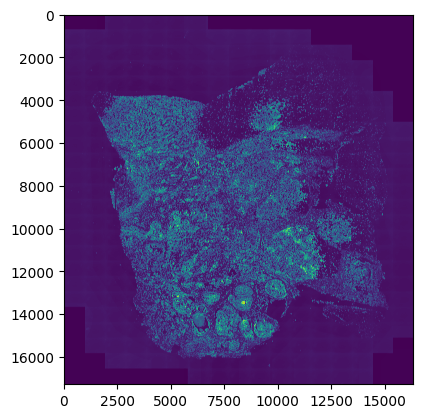

In [60]:
plt.imshow(nuclei)

In [116]:
membrane = merge_channels(channel_to_img, ['Pan-Cytokeratin', 'CD45 (D)', 'CD8', 'CD3e', 'Vimentin-(D)', 'SMA-(D)', 'CD31', 'CD20-(D)'])

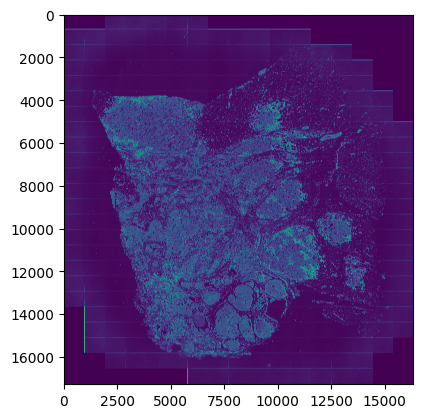

In [117]:
plt.imshow(membrane)

In [107]:
r1, r2, c1, c2, = 9500, 10500, 10000, 11000

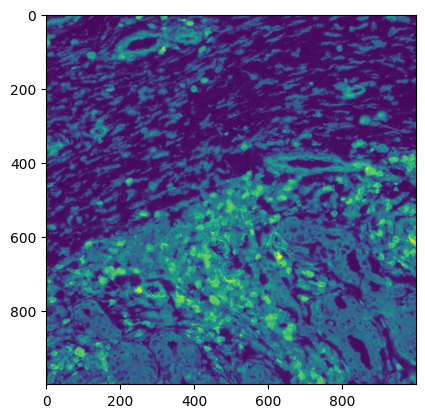

In [108]:
plt.imshow(membrane[r1:r2, c1:c2])

In [109]:
# input_img = np.concatenate((np.expand_dims(nuclei, axis=-1),
#                             np.expand_dims(membrane, axis=-1)), axis=-1)
# input_img = np.expand_dims(input_img, axis=0)
# input_img.shape

In [110]:
input_img = np.concatenate((np.expand_dims(nuclei[r1:r2, c1:c2], axis=-1),
                            np.expand_dims(membrane[r1:r2, c1:c2], axis=-1)), axis=-1)
input_img = np.expand_dims(input_img, axis=0)
input_img.shape

(1, 1000, 1000, 2)

In [111]:
app = Mesmer()

In [112]:
segmentation_predictions = app.predict(input_img, compartment='both')

In [113]:
segmentation_predictions.shape

(1, 1000, 1000, 2)

In [132]:
np.sum(segmentation_predictions[0, ..., 0] > 0), np.sum(segmentation_predictions[0, ..., 1] > 0)

(426767, 363074)

In [114]:
rgb_images = create_rgb_image(input_img, channel_colors=['green', 'blue'])
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions)

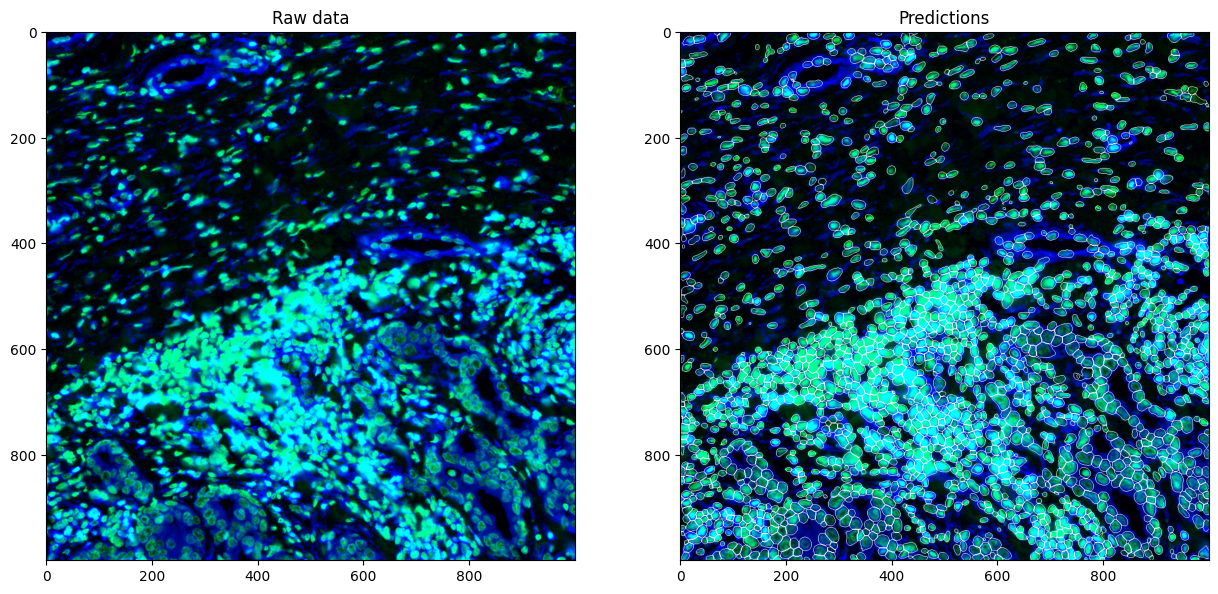

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[0, ...])
ax[1].imshow(overlay_data[0, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()


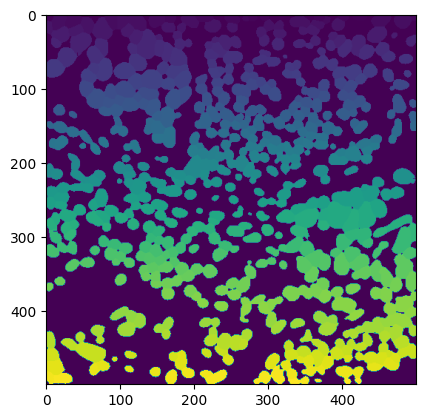

In [89]:
plt.imshow(segmentation_predictions[0, :, :, 0])

In [52]:
r1, r2, c1, c2 = 4000, 5000, 2500, 3500

In [53]:
rgb_images = create_rgb_image(input_img[:, r1:r2, c1:c2, :], channel_colors=['green', 'blue'])
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions[:, r1:r2, c1:c2, :])

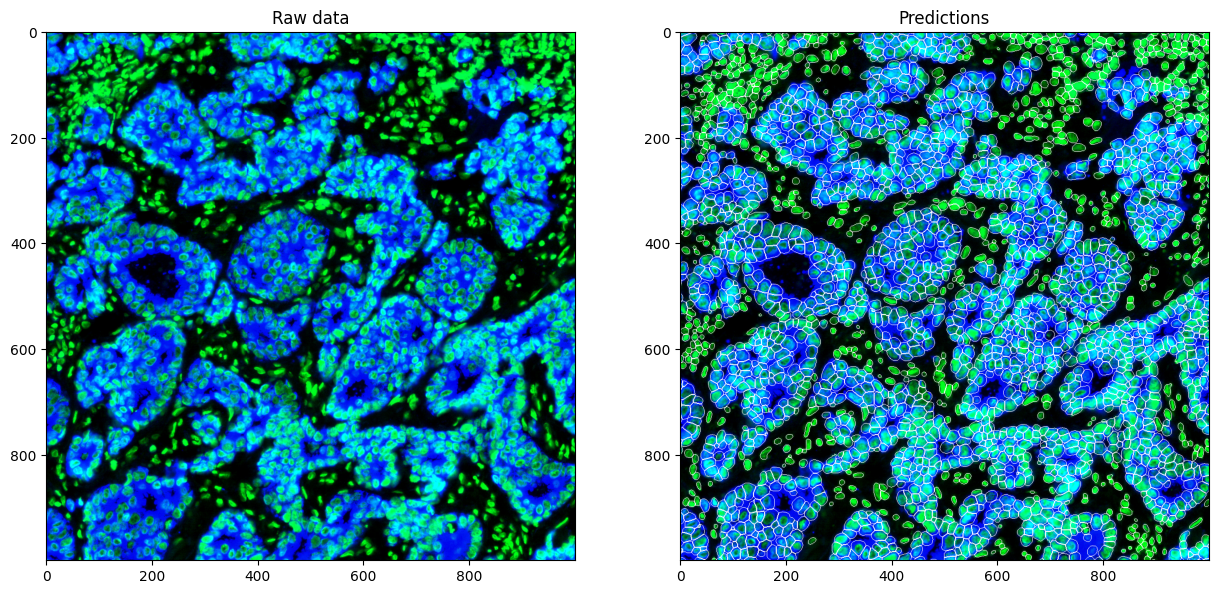

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[0, ...])
ax[1].imshow(overlay_data[0, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()
